## Rossmann Store Sales Analysis

### Data fields
- Id - an Id that represents a (Store, Date) duple within the test set
- Store - a unique Id for each store
- Sales - the turnover for any given day (this is what you are predicting)
- Customers - the number of customers on a given day
- Open - an indicator for whether the store was open: 0 = closed, 1 = open
- StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
- SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
- StoreType - differentiates between 4 different store models: a, b, c, d
- Assortment - describes an assortment level: a = basic, b = extra, c = extended
- CompetitionDistance - distance in meters to the nearest competitor store
- CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
- Promo - indicates whether a store is running a promo on that day
- Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
- Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
- PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

### 1. Importing Libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector

### 2. Load data

In [3]:
store = pd.read_csv("store.csv")
store.shape

(1115, 10)

In [4]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [5]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [6]:
train = pd.read_csv("train.csv")
train.shape

C:\Users\Karl\AppData\Local\Temp\ipykernel_17260\3535696931.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv("train.csv")


(1017209, 9)

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [8]:
train

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1


In [9]:
# Store and Train data should be merged
df = pd.merge(train, store, how='left', on='Store')


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  object 
 8   SchoolHoliday              1017209 non-null  int64  
 9   StoreType                  1017209 non-null  object 
 10  Assortment                 1017209 non-null  object 
 11  CompetitionDistance        1014567 non-null  float64
 12  CompetitionOpenSinceMonth  693861 non-null   float64
 13  CompetitionO

In [11]:
#Date changes type
from datetime import datetime

df['Date'] = pd.to_datetime(df['Date'])

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   Store                      1017209 non-null  int64         
 1   DayOfWeek                  1017209 non-null  int64         
 2   Date                       1017209 non-null  datetime64[ns]
 3   Sales                      1017209 non-null  int64         
 4   Customers                  1017209 non-null  int64         
 5   Open                       1017209 non-null  int64         
 6   Promo                      1017209 non-null  int64         
 7   StateHoliday               1017209 non-null  object        
 8   SchoolHoliday              1017209 non-null  int64         
 9   StoreType                  1017209 non-null  object        
 10  Assortment                 1017209 non-null  object        
 11  CompetitionDistance        1014567 no

Add new column: Sales per Customer

In [13]:
df['Sales per Customer'] = df['Sales']/df['Customers']
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Sales per Customer
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,9.482883
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",9.702400
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",10.126675
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN,9.342457
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN,8.626118


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 19 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   Store                      1017209 non-null  int64         
 1   DayOfWeek                  1017209 non-null  int64         
 2   Date                       1017209 non-null  datetime64[ns]
 3   Sales                      1017209 non-null  int64         
 4   Customers                  1017209 non-null  int64         
 5   Open                       1017209 non-null  int64         
 6   Promo                      1017209 non-null  int64         
 7   StateHoliday               1017209 non-null  object        
 8   SchoolHoliday              1017209 non-null  int64         
 9   StoreType                  1017209 non-null  object        
 10  Assortment                 1017209 non-null  object        
 11  CompetitionDistance        1014567 no

## 3.Preprocessing: Missing Value & Outliers

Missing Values

In [15]:
df.isna().sum()

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance            2642
CompetitionOpenSinceMonth    323348
CompetitionOpenSinceYear     323348
Promo2                            0
Promo2SinceWeek              508031
Promo2SinceYear              508031
PromoInterval                508031
Sales per Customer           172869
dtype: int64

In [16]:
df.isna().mean()

Store                        0.000000
DayOfWeek                    0.000000
Date                         0.000000
Sales                        0.000000
Customers                    0.000000
Open                         0.000000
Promo                        0.000000
StateHoliday                 0.000000
SchoolHoliday                0.000000
StoreType                    0.000000
Assortment                   0.000000
CompetitionDistance          0.002597
CompetitionOpenSinceMonth    0.317878
CompetitionOpenSinceYear     0.317878
Promo2                       0.000000
Promo2SinceWeek              0.499436
Promo2SinceYear              0.499436
PromoInterval                0.499436
Sales per Customer           0.169944
dtype: float64

In [17]:
df[df['Sales per Customer'].isna()]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Sales per Customer
291,292,5,2015-07-31,0,0,0,1,0,1,a,a,1100.0,6.0,2009.0,0,NaN,NaN,NaN,NaN
875,876,5,2015-07-31,0,0,0,1,0,1,a,a,21790.0,4.0,2005.0,1,18.0,2015.0,"Feb,May,Aug,Nov",NaN
1406,292,4,2015-07-30,0,0,0,1,0,1,a,a,1100.0,6.0,2009.0,0,NaN,NaN,NaN,NaN
1990,876,4,2015-07-30,0,0,0,1,0,1,a,a,21790.0,4.0,2005.0,1,18.0,2015.0,"Feb,May,Aug,Nov",NaN
2521,292,3,2015-07-29,0,0,0,1,0,1,a,a,1100.0,6.0,2009.0,0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct",NaN
1017205,1112,2,2013-01-01,0,0,0,0,a,1,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN,NaN
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN,NaN
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN,NaN


In [18]:
df['Sales per Customer'].fillna(0, inplace=True)

In [19]:
df.isna().sum()

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance            2642
CompetitionOpenSinceMonth    323348
CompetitionOpenSinceYear     323348
Promo2                            0
Promo2SinceWeek              508031
Promo2SinceYear              508031
PromoInterval                508031
Sales per Customer                0
dtype: int64

In [20]:
#Unknown으로 처리
df.fillna('Unknown', inplace=True)

In [21]:
df.isna().sum()

Store                        0
DayOfWeek                    0
Date                         0
Sales                        0
Customers                    0
Open                         0
Promo                        0
StateHoliday                 0
SchoolHoliday                0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
Sales per Customer           0
dtype: int64

Outliers

In [22]:
df.describe()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,SchoolHoliday,Promo2,Sales per Customer
count,1.017209e+06,1.017209e+06,1017209,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,2014-04-11 01:30:42.846061824,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01,5.005638e-01,7.880231e+00
min,1.000000e+00,1.000000e+00,2013-01-01 00:00:00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,2013-08-17 00:00:00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.905375e+00
50%,5.580000e+02,4.000000e+00,2014-04-02 00:00:00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,8.683684e+00
75%,8.380000e+02,6.000000e+00,2014-12-12 00:00:00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.051098e+01
max,1.115000e+03,7.000000e+00,2015-07-31 00:00:00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,6.495785e+01
std,3.219087e+02,1.997391e+00,NaN,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01,4.999999e-01,4.089279e+00


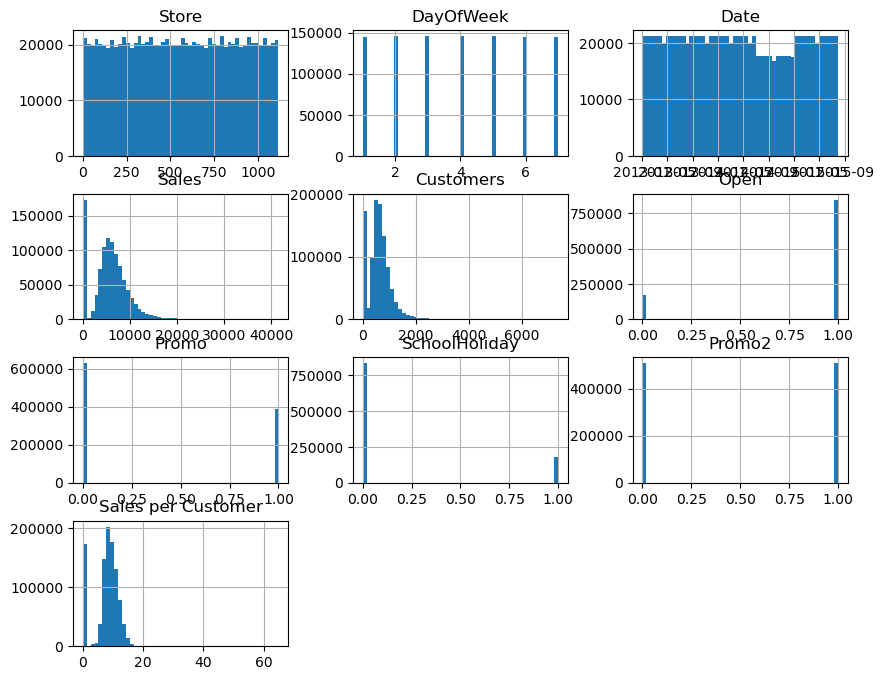

In [23]:
df.hist(bins=50, figsize=(10, 8));

Verify that 'Customer' and 'Sales' are both zero

In [24]:
df_sales = df[df['Sales'] == 0]
df_sales.sort_values(by='Customers', ascending=False).head() #Delete 2 rows

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Sales per Customer
889932,948,4,2013-04-25,0,5,1,1,0,0,b,b,1430.0,Unknown,Unknown,0,Unknown,Unknown,Unknown,0.0
478649,1100,2,2014-04-29,0,3,1,1,0,0,a,a,540.0,Unknown,Unknown,1,14.0,2011.0,"Jan,Apr,Jul,Oct",0.0
291,292,5,2015-07-31,0,0,0,1,0,1,a,a,1100.0,6.0,2009.0,0,Unknown,Unknown,Unknown,0.0
675295,391,7,2013-11-03,0,0,0,0,0,0,a,a,460.0,11.0,2014.0,1,31.0,2013.0,"Feb,May,Aug,Nov",0.0
675297,393,7,2013-11-03,0,0,0,0,0,0,d,c,4820.0,3.0,2008.0,0,Unknown,Unknown,Unknown,0.0


In [25]:
df = df.drop([889932, 478649], axis=0)

In [26]:
df_sales.sort_values(by='Customers', ascending=False).head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Sales per Customer
889932,948,4,2013-04-25,0,5,1,1,0,0,b,b,1430.0,Unknown,Unknown,0,Unknown,Unknown,Unknown,0.0
478649,1100,2,2014-04-29,0,3,1,1,0,0,a,a,540.0,Unknown,Unknown,1,14.0,2011.0,"Jan,Apr,Jul,Oct",0.0
291,292,5,2015-07-31,0,0,0,1,0,1,a,a,1100.0,6.0,2009.0,0,Unknown,Unknown,Unknown,0.0
675295,391,7,2013-11-03,0,0,0,0,0,0,a,a,460.0,11.0,2014.0,1,31.0,2013.0,"Feb,May,Aug,Nov",0.0
675297,393,7,2013-11-03,0,0,0,0,0,0,d,c,4820.0,3.0,2008.0,0,Unknown,Unknown,Unknown,0.0


In [27]:
df_customers = df[df['Customers'] == 0]
df_customers.sort_values(by='Sales', ascending=False).head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Sales per Customer
291,292,5,2015-07-31,0,0,0,1,0,1,a,a,1100.0,6.0,2009.0,0,Unknown,Unknown,Unknown,0.0
675308,404,7,2013-11-03,0,0,0,0,0,0,a,c,1420.0,Unknown,Unknown,1,10.0,2013.0,"Mar,Jun,Sept,Dec",0.0
675300,396,7,2013-11-03,0,0,0,0,0,0,a,c,23130.0,Unknown,Unknown,0,Unknown,Unknown,Unknown,0.0
675301,397,7,2013-11-03,0,0,0,0,0,0,a,c,130.0,Unknown,Unknown,1,27.0,2013.0,"Feb,May,Aug,Nov",0.0
675302,398,7,2013-11-03,0,0,0,0,0,0,c,c,1540.0,Unknown,Unknown,1,1.0,2012.0,"Jan,Apr,Jul,Oct",0.0


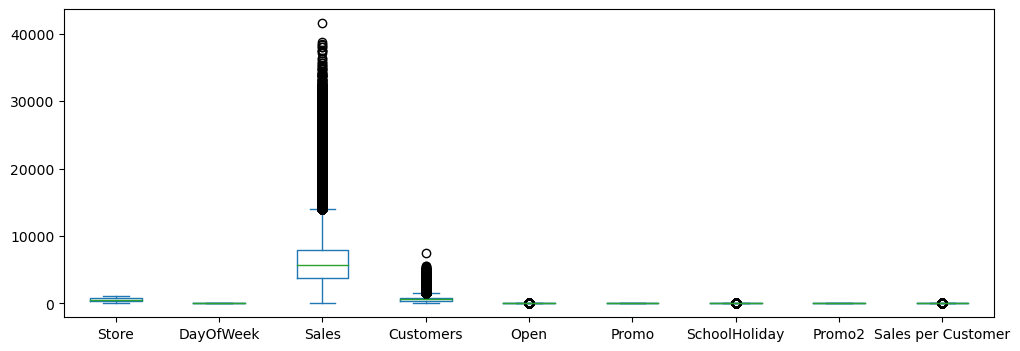

In [28]:
df.plot(kind='box', figsize=(12,4));

 Each store has a different number of customers and sales. Therefore, it is better to group the data by store.

In [29]:
df_group = df.groupby('Store')
df_group['Sales'].describe().sort_values(by='mean', ascending=False).head(10)

,count,mean,std,min,25%,50%,75%,max
Store,,,,,,,,
262,942.0,20718.515924,4668.877584,13210.0,17454.25,19415.5,22125.00,38722.0
817,942.0,18108.139066,9183.542868,0.0,14853.50,20914.0,23897.25,38025.0
562,942.0,17969.556263,2931.927599,8498.0,16078.50,18029.5,19867.75,28680.0
1114,942.0,17200.196391,8343.045630,0.0,16876.00,19556.5,21948.50,35697.0
251,942.0,15814.087049,7924.000164,0.0,15353.00,17640.0,20377.25,35350.0
842,758.0,15242.114776,7914.631921,0.0,13913.50,17375.5,19951.50,35154.0
513,942.0,15129.942675,7426.948520,0.0,14340.00,17032.0,19459.00,31094.0
788,942.0,14949.194268,7303.796656,0.0,14554.25,16549.0,18992.25,32170.0
733,942.0,14933.288747,1838.044097,6838.0,13698.50,14795.5,16092.00,22137.0


In [30]:
df_group['Customers'].describe().sort_values(by='mean', ascending=False).head(10)

,count,mean,std,min,25%,50%,75%,max
Store,,,,,,,,
733,942.0,3403.458599,338.490827,1329.0,3209.00,3393.0,3586.75,4645.0
262,942.0,3402.010616,580.749234,2255.0,3000.00,3239.0,3600.75,5494.0
562,942.0,3105.053079,330.297276,1663.0,2914.25,3127.0,3314.75,4099.0
769,942.0,3081.052017,479.924944,1248.0,2763.50,3079.0,3408.75,4582.0
1114,942.0,2664.057325,1262.650122,0.0,2705.25,3086.0,3407.00,4911.0
817,942.0,2605.488323,1290.924669,0.0,2235.25,3069.5,3416.50,7388.0
1097,942.0,2420.921444,329.306198,1055.0,2245.75,2460.0,2619.00,3804.0
335,942.0,2385.282378,654.315077,482.0,1738.50,2509.5,2890.25,3929.0
259,942.0,2347.112527,448.094646,0.0,2160.00,2414.5,2602.00,3648.0


In [31]:
df_group['Sales per Customer'].describe().sort_values(by='mean', ascending=False).head(10)

,count,mean,std,min,25%,50%,75%,max
Store,,,,,,,,
842,758.0,13.181827,6.238318,0.0,14.772929,15.755875,16.486083,19.573497
612,758.0,13.083789,6.236447,0.0,14.058967,15.438519,16.695032,21.461652
455,942.0,12.998357,6.129076,0.0,13.833040,15.326574,16.555800,19.695568
158,942.0,12.928763,6.032156,0.0,13.909680,15.228210,16.261214,19.679417
868,942.0,12.118065,5.607837,0.0,13.082034,14.326539,15.269210,18.632944
52,758.0,11.975099,5.743632,0.0,12.830845,14.048882,15.269659,20.013233
1115,942.0,11.952081,5.553894,0.0,12.732052,14.021207,15.107823,18.069659
56,942.0,11.909698,5.500707,0.0,13.030408,13.975126,14.924416,18.153213
1068,942.0,11.742211,5.536032,0.0,12.582345,13.873990,14.854118,18.262755


I can see some stores have very high mean values of sales.

<Axes: xlabel='Sales', ylabel='Customers'>

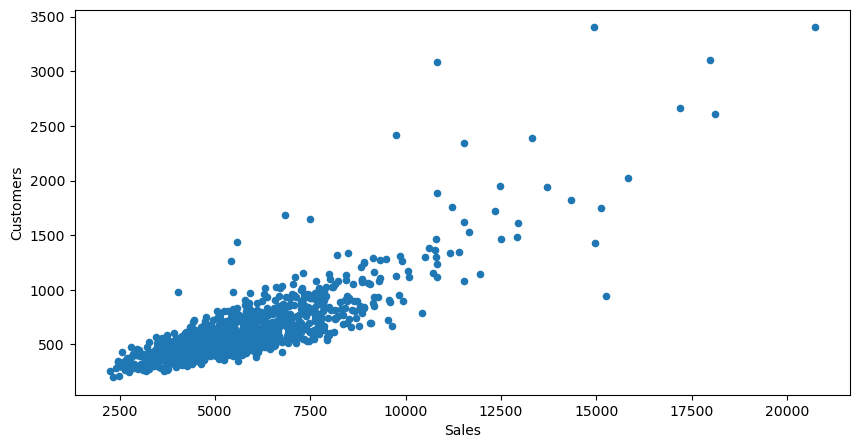

In [32]:
mean_values = df_group[['Sales','Customers','Sales per Customer']].mean()
mean_values.plot(kind='scatter', x='Sales', y='Customers', figsize=(10, 5))

I've observed some 'Sales' outliers in certain stores. However, deleting all stores with outliers is inadvisable, as they might represent important factors worth investigating. First, I'll remove rows with zero values in both 'Sales' and 'Customers' before proceeding.

In [33]:
df_zero = df[df['Sales'] != 0]

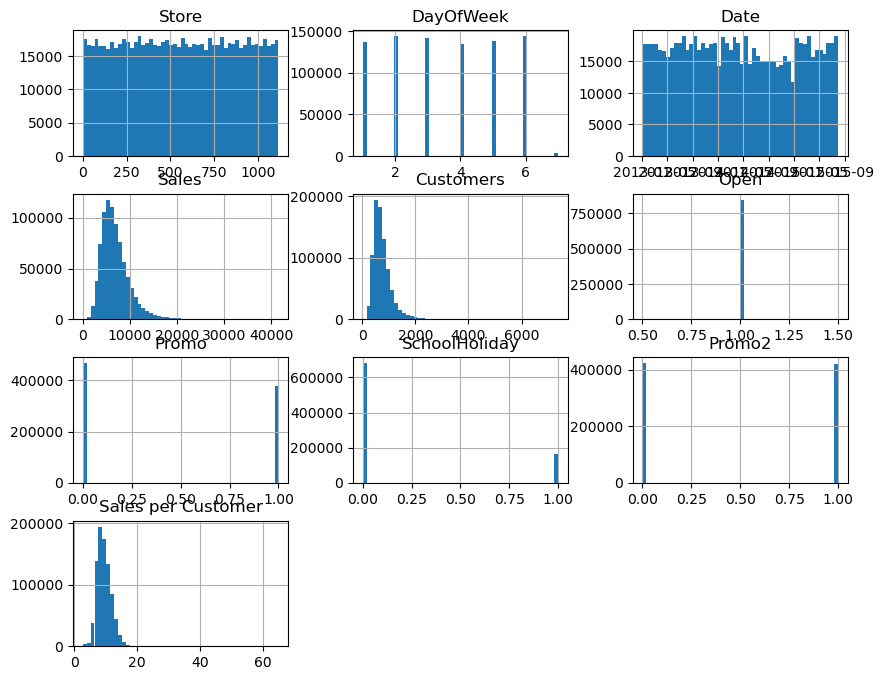

In [34]:
df_zero.hist(bins=50, figsize=(10, 8));

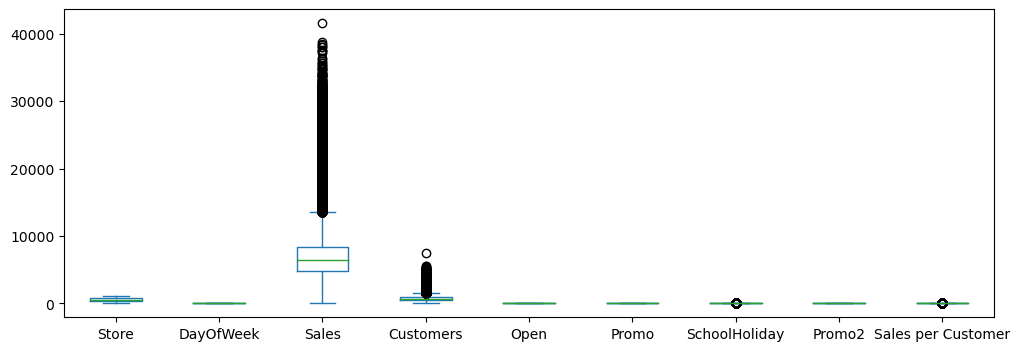

In [35]:
df_zero.plot(kind='box', figsize=(12,4));

<Axes: >

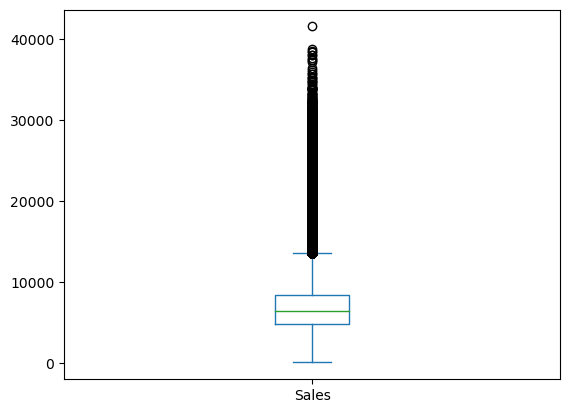

In [36]:
df_zero['Sales'].plot.box()

In [37]:
Q1 = df_zero['Sales'].quantile(0.25)
Q3 = df_zero['Sales'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR 

IQR

3501.0

In [38]:
df_zero_i = df_zero[~((df_zero['Sales'] < lower_bound) | (df_zero['Sales'] > upper_bound))].sort_values(by='Sales')

<Axes: >

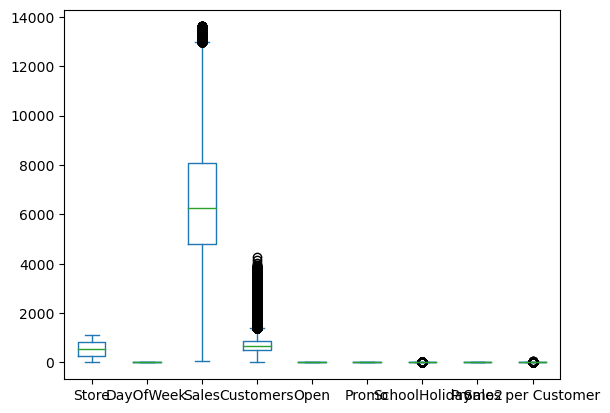

In [39]:
df_zero_i.plot.box()

In [40]:
Q1 = df_zero['Customers'].quantile(0.25)
Q3 = df_zero['Customers'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR 

IQR

374.0

In [41]:
df_zero_ii = df_zero_i[~((df_zero['Customers'] < lower_bound) | (df_zero_i['Customers'] > upper_bound))].sort_values(by='Customers')

C:\Users\Karl\AppData\Local\Temp\ipykernel_17260\150847158.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_zero_ii = df_zero_i[~((df_zero['Customers'] < lower_bound) | (df_zero_i['Customers'] > upper_bound))].sort_values(by='Customers')


<Axes: >

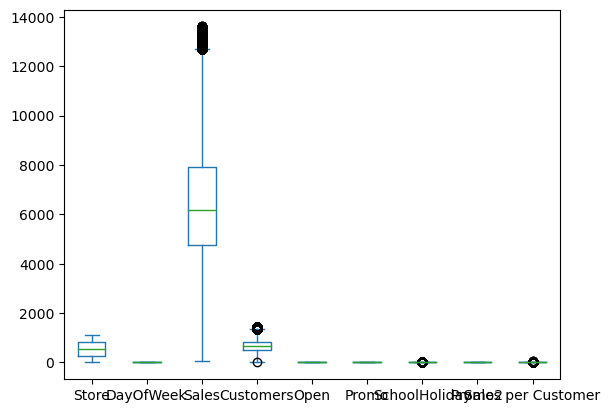

In [42]:
df_zero_ii.plot.box()

In [43]:
df_1 = df_zero_ii

## 4.Normality Test

Skewness and Kurtosis

In [44]:
df_1['Sales'].skew(), df_1['Sales'].kurt()

(0.5153813058018539, -0.09488721861162963)

Sales

Skewness: This value indicates a slight positive skew. 


Kurtosis: This value indicates near-normal kurtosis.

In [45]:
df_1['Customers'].skew(), df_1['Customers'].kurt()


(0.6128531705829503, 0.019398471559975317)

Customers

Skewness: This value indicates a moderate positive skew.

Kurtosis: This value indicates platykurtosis.

부트스트래핑

In [46]:
sample_means = []
n_samples = 1000  # 표본 추출 횟수
sample_size = 50   # 각 표본의 크기

for _ in range(n_samples):
    sample = df_1["Sales"].sample(n=sample_size)
    sample_means.append(sample.mean())

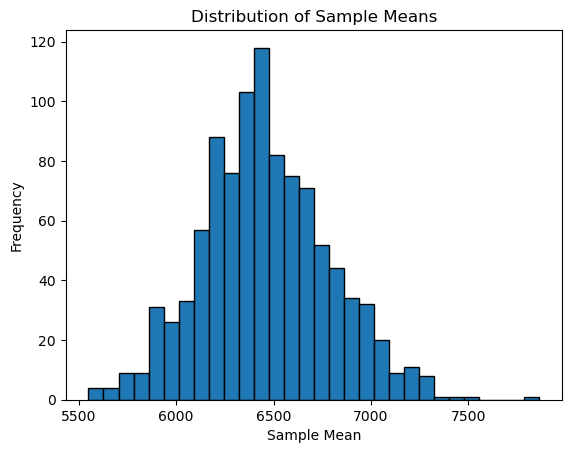

In [47]:
plt.hist(sample_means, bins=30, edgecolor='black')
plt.title('Distribution of Sample Means')
plt.xlabel('Sample Mean')
plt.ylabel('Frequency')
plt.show()

In [48]:
sample_means = []
n_samples = 1000  # 표본 추출 횟수
sample_size = 50   # 각 표본의 크기

for _ in range(n_samples):
    sample = df_1["Customers"].sample(n=sample_size)
    sample_means.append(sample.mean())

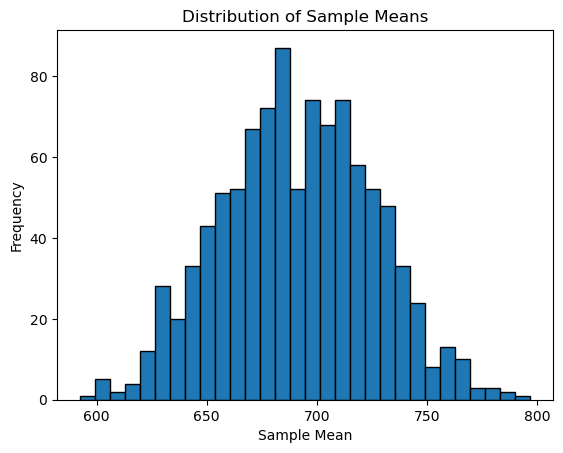

In [49]:
plt.hist(sample_means, bins=30, edgecolor='black')
plt.title('Distribution of Sample Means')
plt.xlabel('Sample Mean')
plt.ylabel('Frequency')
plt.show()

Stratified sampling

In [51]:
df_1['Store'].value_counts(normalize=True)

Store
494    0.001176
578    0.001117
530    0.001111
732    0.001111
209    0.001111
         ...   
769    0.000005
817    0.000005
698    0.000005
251    0.000005
733    0.000003
Name: proportion, Length: 1113, dtype: float64

In [53]:
df_1['Store'].value_counts(1).sum()

1.0

In [54]:
df_1

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Sales per Customer
273387,652,6,2014-11-22,46,8,1,0,0,0,a,a,20390.0,Unknown,Unknown,0,Unknown,Unknown,Unknown,5.750000
202712,898,6,2015-01-31,124,13,1,0,0,0,a,a,18540.0,Unknown,Unknown,0,Unknown,Unknown,Unknown,9.538462
846592,1093,1,2013-06-03,133,18,1,1,0,0,c,c,10450.0,6.0,2009.0,0,Unknown,Unknown,Unknown,7.388889
996161,137,6,2013-01-19,297,36,1,0,0,0,a,a,1730.0,7.0,2015.0,1,40.0,2014.0,"Jan,Apr,Jul,Oct",8.250000
941137,863,7,2013-03-10,286,40,1,0,0,0,a,c,21370.0,11.0,2010.0,0,Unknown,Unknown,Unknown,7.150000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
708483,129,5,2013-10-04,11335,1454,1,0,0,0,a,a,2460.0,Unknown,Unknown,1,14.0,2011.0,"Jan,Apr,Jul,Oct",7.795736
540322,333,2,2014-03-04,11552,1454,1,1,0,1,a,c,3720.0,2.0,2010.0,0,Unknown,Unknown,Unknown,7.944979
660413,4,6,2013-11-16,10157,1454,1,0,0,0,c,c,620.0,9.0,2009.0,0,Unknown,Unknown,Unknown,6.985557
140614,125,5,2015-03-27,10930,1454,1,0,0,0,a,a,760.0,12.0,2005.0,0,Unknown,Unknown,Unknown,7.517194


In [55]:
# 월별 지출(Sales) 데이터 추출
sales_1 = df_1['Sales']

# 점추정: 월별 지출의 표본 평균 계산
point_estimate = sales_1.mean()
print(point_estimate)

# 구간 추정: 95% 신뢰구간 계산
# 표본 크기, 표본 평균, 표본 표준편차 계산
sample_size = len(sales_1)
sample_mean = sales_1.mean()
# 표본 표준편차 (자유도 n-1 사용)
sample_std = np.std(sales_1, ddof=1)
sample_std

6477.0031720007655


2328.83213160322

In [57]:
df_1

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Sales per Customer
273387,652,6,2014-11-22,46,8,1,0,0,0,a,a,20390.0,Unknown,Unknown,0,Unknown,Unknown,Unknown,5.750000
202712,898,6,2015-01-31,124,13,1,0,0,0,a,a,18540.0,Unknown,Unknown,0,Unknown,Unknown,Unknown,9.538462
846592,1093,1,2013-06-03,133,18,1,1,0,0,c,c,10450.0,6.0,2009.0,0,Unknown,Unknown,Unknown,7.388889
996161,137,6,2013-01-19,297,36,1,0,0,0,a,a,1730.0,7.0,2015.0,1,40.0,2014.0,"Jan,Apr,Jul,Oct",8.250000
941137,863,7,2013-03-10,286,40,1,0,0,0,a,c,21370.0,11.0,2010.0,0,Unknown,Unknown,Unknown,7.150000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
708483,129,5,2013-10-04,11335,1454,1,0,0,0,a,a,2460.0,Unknown,Unknown,1,14.0,2011.0,"Jan,Apr,Jul,Oct",7.795736
540322,333,2,2014-03-04,11552,1454,1,1,0,1,a,c,3720.0,2.0,2010.0,0,Unknown,Unknown,Unknown,7.944979
660413,4,6,2013-11-16,10157,1454,1,0,0,0,c,c,620.0,9.0,2009.0,0,Unknown,Unknown,Unknown,6.985557
140614,125,5,2015-03-27,10930,1454,1,0,0,0,a,a,760.0,12.0,2005.0,0,Unknown,Unknown,Unknown,7.517194
